# Introduction to Data Science – Lecture 11 – APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"iss_position": {"longitude": "-12.7003", "latitude": "-37.5190"}, "timestamp": 1581461225, "message": "success"}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"iss_position": {"longitude": "-12.7003", "latitude": "-37.5190"}, "timestamp": 1581461225, "message": "success"}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'iss_position': {'longitude': '-12.7003', 'latitude': '-37.5190'}, 'timestamp': 1581461225, 'message': 'success'}


{'longitude': '-12.7003', 'latitude': '-37.5190'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,iss_position,timestamp,message
latitude,-37.5190,2020-02-11 22:47:05,success
longitude,-12.7003,2020-02-11 22:47:05,success


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '-37.5190', 'longitude': '-12.7003', 'timestamp': 1581461225}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '-50.8303', 'longitude': '24.2895', 'timestamp': 1581461698}
{'latitude': '-50.8655', 'longitude': '24.5791', 'timestamp': 1581461701}
{'latitude': '-50.9000', 'longitude': '24.8692', 'timestamp': 1581461704}
{'latitude': '-50.9337', 'longitude': '25.1597', 'timestamp': 1581461707}
{'latitude': '-50.9667', 'longitude': '25.4507', 'timestamp': 1581461710}
{'latitude': '-50.9988', 'longitude': '25.7420', 'timestamp': 1581461713}
{'latitude': '-51.0301', 'longitude': '26.0338', 'timestamp': 1581461716}
{'latitude': '-51.0607', 'longitude': '26.3259', 'timestamp': 1581461719}
{'latitude': '-51.0904', 'longitude': '26.6184', 'timestamp': 1581461722}
{'latitude': '-51.1194', 'longitude': '26.9113', 'timestamp': 1581461725}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2020-02-11 22:54:58,-50.8303,24.2895,2020-02-11 22:54:58
2020-02-11 22:55:01,-50.8655,24.5791,2020-02-11 22:55:01
2020-02-11 22:55:04,-50.9000,24.8692,2020-02-11 22:55:04
2020-02-11 22:55:07,-50.9337,25.1597,2020-02-11 22:55:07
2020-02-11 22:55:10,-50.9667,25.4507,2020-02-11 22:55:10
2020-02-11 22:55:13,-50.9988,25.7420,2020-02-11 22:55:13
2020-02-11 22:55:16,-51.0301,26.0338,2020-02-11 22:55:16
2020-02-11 22:55:19,-51.0607,26.3259,2020-02-11 22:55:19
2020-02-11 22:55:22,-51.0904,26.6184,2020-02-11 22:55:22


Let's see how the ISS moves

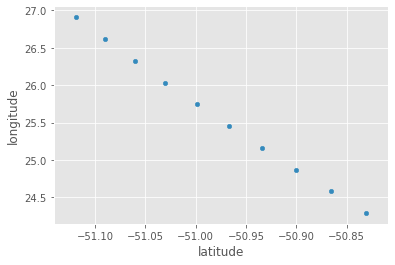

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1581461230,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 656, 'risetime': 1581464789},
  {'duration': 547, 'risetime': 1581470627},
  {'duration': 622, 'risetime': 1581524976},
  {'duration': 645, 'risetime': 1581530768},
  {'duration': 576, 'risetime': 1581536654}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2020-02-11 23:46:29')

So, the ISS will be above SLC tonight!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [14]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
# you will have to load your own credentials here.
from credentials_alex import * 
twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET)

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [15]:
tag = "#resist"
result = twitter.search(q=tag, tweet_mode="extended")
result

{'statuses': [{'created_at': 'Tue Feb 11 23:08:08 +0000 2020',
   'id': 1227368753488441345,
   'id_str': '1227368753488441345',
   'full_text': "@thehill Don't have a fav candidate. Blue no matter who..\nBut, Joe deserves RESPECT for handling attacks by Trump &amp; the Traitors &amp; FOX 24/7.  No one should have to deal with that to run for public service. @JoeBiden Think about it. #Resist",
   'truncated': False,
   'display_text_range': [9, 247],
   'entities': {'hashtags': [{'text': 'Resist', 'indices': [240, 247]}],
    'symbols': [],
    'user_mentions': [{'screen_name': 'thehill',
      'name': 'The Hill',
      'id': 1917731,
      'id_str': '1917731',
      'indices': [0, 8]},
     {'screen_name': 'JoeBiden',
      'name': 'Joe Biden (Text Join to 30330)',
      'id': 939091,
      'id_str': '939091',
      'indices': [214, 223]}],
    'urls': []},
   'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
   'source': '<a href="https://mobile.twitter.com" rel="nofo

The result is an array of tweets, we can look at specific text:

In [16]:
result["statuses"][0]["full_text"]

"@thehill Don't have a fav candidate. Blue no matter who..\nBut, Joe deserves RESPECT for handling attacks by Trump &amp; the Traitors &amp; FOX 24/7.  No one should have to deal with that to run for public service. @JoeBiden Think about it. #Resist"

Or print all the tweets:

In [17]:
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

@thehill Don't have a fav candidate. Blue no matter who..
But, Joe deserves RESPECT for handling attacks by Trump &amp; the Traitors &amp; FOX 24/7.  No one should have to deal with that to run for public service. @JoeBiden Think about it. #Resist
----
RT @Nikki29977810: #ImpeachBarrNow #VoteThemAllOut2020 #TraitorTrump  #Resist https://t.co/C35VvXK69Q
----
RT @jvgraz: I can't understand why Democrats tolerate these kinds of attacks on our frontrunner, Bernie Sanders. This is divisive when we n…
----
RT @pescara121: @MysterySolvent GETTHIS ORANGE MOTHER FUCKER OUT OF THATWHITE HOUSE!!!! AND TAKE YOUR FUCKING KIDS WITH YOU.. phew.... that…
----
RT @jvgraz: I can't understand why Democrats tolerate these kinds of attacks on our frontrunner, Bernie Sanders. This is divisive when we n…
----
RT @jvgraz: I can't understand why Democrats tolerate these kinds of attacks on our frontrunner, Bernie Sanders. This is divisive when we n…
----
RT @AngelaBelcamino: OMG!!! Almost 120K followers! 
In c

## Analysis of Twitter Popularity

Let's do a brief analysis of twitter popularity of two presidential candidates: Donald Trump and Elizabeth Warren. As you would expect, Trump has a lot more twitter followers (74 million) than Warren (4 million). As an aside, Barack Obama has 113 million followers, and Justin Bieber has 110 million. 

We can search for tweets based on usernames:

In [18]:
result = twitter.search(q="@realDonaldTrump",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @chukwu_onochie: Barrister Ifeanyi Ejiofor called on the federal government to immediately withdraw the military personnels deployed to…
----
RT @k_ovfefe: @realDonaldTrump I LOVE YOU MR PRESIDENT https://t.co/4MwbLPSLBV
----
RT @realDonaldTrump: New Stock Market RECORD. Congratulations, spend your money wisely. KEEP AMERICA GREAT!!!!!
----
RT @Mike_Pence: It has been three years of Promises Made and Promises Kept under President @realDonaldTrump, and we’re just getting started…
----
RT @2runtherace: FBI probing Joe, Hunter Biden corruption? ‘We do not talk about open investigations’ (VIDEO) – True Pundit
#HuntersBecomeH…
----
@realDonaldTrump YOU ARE THE SWAMP. And we will drain you in November.
----
@youre_kidding1 @SheliaM49445270 @NRA @NRACountry @realDonaldTrump Too many gun that are too easy to get. Why does America need an average of 1 gun for every man, woman &amp; child? Good for the gun industry; bad for citizens, especially those innocents who die needlessly from gun viol

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download Trump's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [19]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
trump_result = twitter.get_user_timeline(screen_name="realDonaldTrump", count=50)
trump_result

[{'created_at': 'Tue Feb 11 18:22:51 +0000 2020',
  'id': 1227296958886424584,
  'id_str': '1227296958886424584',
  'text': 'RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN and then, KEEP AMERICA GREAT!',
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'realDonaldTrump',
     'name': 'Donald J. Trump',
     'id': 25073877,
     'id_str': '25073877',
     'indices': [3, 19]}],
   'urls': []},
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 25073877,
   'id_str': '25073877',
   'name': 'Donald J. Trump',
   'screen_name': 'realDonaldTrump',
   'location': 'Washington, DC',
   'description': '45th President of the United States of America🇺🇸',
   'url': 'https://t.co/OMxB0x7xC5',
   'entities': {'ur

Let's count the numbers for Trump's favorites and retweets.

In [20]:
trump_favorites = []
trump_retweets = []
trump_texts = []
for status in trump_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    trump_favorites.append(status["favorite_count"])
    trump_retweets.append(status["retweet_count"])
    trump_texts.append(status["text"])

RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN and then, KEEP AMERICA GREAT!
0
----
RT @realDonaldTrump: DRAIN THE SWAMP!
0
----
RT @Jim_Jordan: President Trump’s budget sets the right priorities:

-Funds the wall
-Supports our military
-Cuts wasteful foreign aid
-Ena…
0
----
RT @realDonaldTrump: 95% Approval Rating in the Republican Party, a Record! 53% overall (plus add 9 points?). Corrupt Democrat politicians…
0
----
RT @realDonaldTrump: Wall Street Journal Editorial: “She (Crazy Nancy) aimed at Trump and hit Uncle Joe.”
0
----
RT @realDonaldTrump: “A lot of people feel defeated...Trump always wins. It seems like nothing can stop him.” Danny Villazon  @nytimes @Dan…
0
----
RT @realDonaldTrump: THANK YOU NEW HAMPSHIRE! 
https://t.co/dvZq0UPjHI
0
----
RT @realDonaldTrump: TOUGH GUYS FOR TRUMP! https://t.co/DbjZjGzLWU
0
----
RT @realDonaldTrump: BEST USA ECONOMY IN HISTORY!
0
----
When Jerome Powell started his testimony today, the Dow was up 125, &amp; heading higher. As he spoke it dr

Now let's do the same for Elizabeth Warren.

In [21]:
warren_results = twitter.get_user_timeline(screen_name="ewarren", count=50)
warren_results

[{'created_at': 'Tue Feb 11 23:10:49 +0000 2020',
  'id': 1227369428070936578,
  'id_str': '1227369428070936578',
  'text': "People are worried the fight against Donald Trump may be unwinnable. But I've been winning “unwinnable” fights my w… https://t.co/QSxHvHP61O",
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'https://t.co/QSxHvHP61O',
     'expanded_url': 'https://twitter.com/i/web/status/1227369428070936578',
     'display_url': 'twitter.com/i/web/status/1…',
     'indices': [117, 140]}]},
  'source': '<a href="https://studio.twitter.com" rel="nofollow">Twitter Media Studio</a>',
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'in_reply_to_screen_name': None,
  'user': {'id': 357606935,
   'id_str': '357606935',
   'name': 'Elizabeth Warren',
   'screen_name': 'ewarren',
   'location': 'Massachusetts',
   'description': 'U.S.

In [22]:
warren_favorites = []
warren_retweets = []
warren_texts = []
for status in warren_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    warren_favorites.append(status["favorite_count"])
    warren_retweets.append(status["retweet_count"])
    warren_texts.append(status["text"])

People are worried the fight against Donald Trump may be unwinnable. But I've been winning “unwinnable” fights my w… https://t.co/QSxHvHP61O
77
----
RT @TeamWarren: Hey New Hampshire, be sure to vote today if you haven’t already! 🗳️

Your voice is powerful—and a vote for @ewarren is a st…
0
----
Stopped by some polling locations in New Hampshire for donuts and selfies! Polls are still open, confirm your polli… https://t.co/xZmlrndM2E
828
----
From Rochester to Portsmouth, New Hampshire, and all across the country, Americans are ready to make this country w… https://t.co/TSOLrNlsXK
835
----
Thank you for fighting alongside me @IoMcCoy—I’ll keep fighting to make sure that you and every person in America g… https://t.co/FxVkNAPsB0
583
----
Beth is still paying off her student loans, even as her daughter is about to start college. That's why I've got a p… https://t.co/8Jc70LqJDQ
1740
----
RT @TeamWarren: We have a plan to organize in all 57 states and territories, continue to meet people w

And let's create DataFrames for both of them and explore their stats:

In [23]:
trump_stats = pd.DataFrame({
        "Trump Fav":trump_favorites,
        "Trump RT":trump_retweets,
        "Trum Text":trump_texts
    })

warren_stats = pd.DataFrame({
      "Warren Fav":warren_favorites,
      "Warren RT":warren_retweets, 
      "Warren Text":warren_texts
        })

In [24]:
trump_stats.head()

,Trump Fav,Trump RT,Trum Text
0,0,41434,RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN ...
1,0,38582,RT @realDonaldTrump: DRAIN THE SWAMP!
2,0,18737,RT @Jim_Jordan: President Trump’s budget sets ...
3,0,28951,RT @realDonaldTrump: 95% Approval Rating in th...
4,0,21950,RT @realDonaldTrump: Wall Street Journal Edito...


In [25]:
trump_stats.describe()

,Trump Fav,Trump RT
count,50.000000,50.000000
mean,52065.380000,21030.660000
std,64112.706907,13510.768846
min,0.000000,4476.000000
25%,0.000000,9688.750000
50%,16597.000000,18360.000000
75%,92722.750000,27166.000000
max,213966.000000,56422.000000


In [26]:
warren_stats.describe()

,Warren Fav,Warren RT
count,50.000000,50.000000
mean,3404.680000,954.120000
std,5605.130603,1777.845826
min,0.000000,25.000000
25%,203.500000,222.000000
50%,1623.000000,409.000000
75%,3814.250000,929.500000
max,30923.000000,11686.000000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [27]:
trump_stats = trump_stats.sort_values("Trump Fav", ascending=False)
trump_stats = trump_stats.reset_index(drop=True)
trump_stats.head(30)

,Trump Fav,Trump RT,Trum Text
0,213966,52453,TOUGH GUYS FOR TRUMP! https://t.co/DbjZjGzLWU
1,213037,41434,"MAKE AMERICA GREAT AGAIN and then, KEEP AMERIC..."
2,187616,56422,FBI Director Christopher Wray just admitted th...
3,182609,38582,DRAIN THE SWAMP!
4,152471,27166,BEST USA ECONOMY IN HISTORY!
5,141057,28951,"95% Approval Rating in the Republican Party, a..."
6,124487,25477,"Hope the Fake News, which never discusses it, ..."
7,123141,26640,Because of how badly they did with the Impeach...
8,112609,24032,“A lot of people feel defeated...Trump always ...
9,107832,33997,....This is the biggest political crime in Ame...


In [28]:
trump_stats.tail(10)

,Trump Fav,Trump RT,Trum Text
40,0,7477,RT @ChuckRossDC: A *9 year* prison recommendat...
41,0,4476,RT @JudicialWatch: BREAKING: @TomFitton made t...
42,0,7844,RT @paulsperry_: BREAKING: Like the Steele Dos...
43,0,7642,"RT @paulsperry_: ""If we ever find out that the..."
44,0,8609,RT @paulsperry_: BREAKING: FBI Director Wray i...
45,0,9282,RT @paulsperry_: BREAKING: Dana Boente was the...
46,0,11429,RT @paulsperry_: BREAKING:Gabriel Sanz-Rexach ...
47,0,6949,RT @josepheschmitz: President Trump should sue...
48,0,38582,RT @realDonaldTrump: DRAIN THE SWAMP!
49,0,5623,RT @paulsperry_: BREAKING: How ‘Whistleblower’...


In [29]:
warren_stats = warren_stats.sort_values("Warren Fav", ascending=False)
warren_stats = warren_stats.reset_index(drop=True)
warren_stats.head(30)

,Warren Fav,Warren RT,Warren Text
0,30923,11686,$756 billion in Medicare cuts\n$920 billion in...
1,22245,4212,We can let fear consume us and divide us—or we...
2,11378,2634,People are worried that the fight against Dona...
3,10496,2431,"The way I see it, as Democrats running for the..."
4,10196,3490,Anwar is a photographer who volunteered with h...
5,7232,1887,"New Hampshire, you have a decision to make. Wi..."
6,6509,1554,"We launched this grassroots movement for big, ..."
7,5933,1187,"At Sunday’s town hall in Lebanon, New Hampshir..."
8,5564,1401,This is corruption plain and simple. Our gover...
9,4914,1804,The Trump administration is attempting to depo...


In [30]:
combined = warren_stats.copy()
combined["Trump Fav"] = trump_stats["Trump Fav"]
combined["Trump RT"] = trump_stats["Trump RT"]

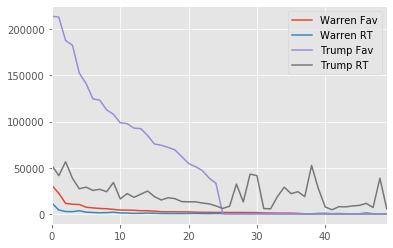

In [31]:
combined.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.